# This notebook

* Explores the x and y parameters in the plot
    * Serialized into functions

In [1]:
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pickle


import sys
import os
sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/codes'))
from jason import plotting_def, plot_prettier

plotting_def()

# The function

In [2]:
"""Define constants"""

class unit():
    def __init__(self):        
        # length, time, and mass constants
        self.CONST_pc  = 3.086e18
        self.CONST_yr  = 3.154e7
        self.CONST_amu = 1.66053886e-24
        self.CONST_kB  = 1.3806505e-16
        self.unit_length = self.CONST_pc*1e3  # 1 kpc
        self.unit_time   = self.CONST_yr*1e6  # 1 Myr
        self.unit_density = self.CONST_amu    # 1 mp/cm-3
        self.unit_velocity = self.unit_length/self.unit_time
        self.KELVIN = self.unit_velocity*self.unit_velocity*self.CONST_amu/self.CONST_kB
        self.unit_q = (self.unit_density * (self.unit_velocity**3))/self.unit_length
        self.g = 5/3
        
        # avg atomic mass
        Xsol = 1.0
        Zsol = 1.0
        
        X = Xsol * 0.7381
        Z = Zsol * 0.0134
        Y = 1 - X - Z
        
        self.mu  = 1.0/(2.*X+ 3.*(1.-X-Z)/4.+ Z/2.);
        self.mue = 2.0/(1.0+X);
        self.muH = 1.0/X;
        self.mH = 1.0

        # alpha values for different sims
        self.alpha_hyd = 2 ** (1 / 3)  # 1.26 # 1.383
        self.alpha_mhd = (2 * 4.2 / 0.77) ** (1 / 3)

u = unit()
u.mu

0.5990624672387714

In [3]:
def calc_T(P, rho):
    """
    Calculates temeprature from constants
    ----------
    P: gas pressure
    rho: gas density
    """
    T = P/rho * u.KELVIN * u.mu
    return T

def calc_cs(T):
    """
    Calculates sound speed
    ----------
    T: temperature
    mu: avg atomic number of the gas
    """
    # convert to cm
    m_to_cm = 100

    # return np.sqrt(g.g*R*T_hot/M) * m_to_cm/g.unit_velocity
    # return np.sqrt(u.g * u.CONST_kB / (u.mu * u.CONST_amu) * T) * m_to_cm / u.unit_velocity
    return np.sqrt(u.g * u.CONST_kB / (u.mu * u.CONST_amu) * T) / u.unit_velocity

def calc_mach(v_turb, P, rho):
    """
    Calculates the Mach number
    ----------
    v_turb: turbulence velocity
    P, rho
    """
    T = calc_T(P, rho)
    cs = calc_cs(T)
    print(f'cs = {cs}')
    return v_turb / cs

def calc_dedt_mach(mach, P, rho, L):
    """
    Returns required dedt for a given Mach number, density, temperature, and box size
    """
    # calculate sound speed first
    T = calc_T(P, rho)
    cs_new = calc_cs(T)
    print(f"cs_hot: {cs_new}")

    dedt_req = rho * (cs_new**3) * (L**2) * (mach**3) / (u.alpha_hyd**3)
    return dedt_req


def calc_dedt_vturb(v_turb, rho, L):
    """
    Returns required dedt for a given turbulent velocity, density, and box size

    Does NOT calculate sound speed, so no pressure required
    """
    
    dedt_req = rho * v_turb**3 * (L**2) / (u.alpha_hyd**3)
    return dedt_req

def find_ind_l(seq, val):
    seq = list(seq)
    return seq.index(list(filter(lambda x: x>val, seq))[0])

In [4]:
import pickle

# trial = '240606_0.6_5'  # for 4e4 plot
# trial = '240610_0.6_2032'  # for 8e3 plot

def load_lshat(rp = None, verbose = False):
    # Import the cooling function from Hitesh's scripts
    import sys
    sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/athena/cooling_scripts'))
    import cooling_fn as cf
    sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/athena/helper_scripts'))
    import v_turb as vt

    # temperature range
    T_arr = np.logspace(np.log10(rp['T_floor']),
                        np.log10(rp['T_ceil']), 100)  # in kelvin
    rho_arr = rp['rho_hot'] * rp['T_hot'] / T_arr
    
    """
    Cooling & Heating functions
    """
    Gamma_n_arr = 1e-26 / rho_arr
    Lambda_arr = np.vectorize(cf.Lam_fn_powerlaw)(T_arr, Zsol=1.0, Lambda_fac=1.0)
    
    """
    Cooling & Heating rates
    """
    heating_rate = 1e-26 * rho_arr
    cooling_rate = Lambda_arr * rho_arr**2
    
    """
    Timescale
    """
    tcool_arr = np.vectorize(cf.tcool_calc)(
        rho_arr, T_arr, Zsol=1.0, Lambda_fac=1.0, fit_type="max"
    )

    """
    Shattering length
    """
    def calc_cs(T):
        m_to_cm = 100
        return np.sqrt(u.g * u.CONST_kB / (u.mu * u.CONST_amu) * T) / u.unit_velocity
    t_cool_func = lambda T : cf.tcool_calc(rp['rho_hot'] * rp['T_hot'] / T, T, Zsol=1.0, Lambda_fac=1.0, fit_type="max")
    l_shatter = np.vectorize(t_cool_func)(T_arr) * calc_cs(T_arr)

    """
    Minimum l_shatter
    """
    # calculate geometric mean T_mix
    # the two limits
    T_cold = rp['T_cloud']  # set cold temperature to that of cloud
    T_hot = rp['T_hot']
    
    print(f'T_cold = {T_cold}')
    print(f'T_hot = {T_hot:.2e}')
    T_mix = np.sqrt(T_cold * T_hot)
    print(f'T_mix = {T_mix:.2e}')
    
    t_cool_mix = t_cool_func(T_mix)
    t_cool_cold = t_cool_func(T_cold)
    print(f't_cool,mix = {t_cool_mix:.2e}')
    print(f't_cool,cold = {t_cool_cold:.2e}')
    
    t_cool_min = np.min(tcool_arr[find_ind_l(T_arr, T_cold) : find_ind_l(T_arr, T_hot)])
    print(f't_cool_min = {t_cool_min:.2e}')
    
    l_shatter_min = np.min(l_shatter[find_ind_l(T_arr, T_cold) : find_ind_l(T_arr, T_hot)])
    print(f'l_shatter_min = {l_shatter_min:.2e}')
    
    def plot_tvlines():
        plt.axvline(x=rp['T_floor'], color="k", linestyle="--")
        plt.axvline(x=rp['T_cloud'], color="slateblue", linestyle="--")
        plt.axvline(x=rp['T_mix'], color="green", linestyle="--", alpha=0.2)
        plt.axvline(x=rp['T_hot'], color="orangered", linestyle="--")
        # plt.axvline(x=T_cut color="k", linestyle="")
    
    if verbose:
        """Cooling function"""
        plt.figure(figsize=(4, 3))
        plt.plot(T_arr, Lambda_arr, label=r"$\Lambda(T)$")
        
        plt.ylabel(r"$\Lambda(T)$  $[10^{-23}  \mathrm{ergs ~ cm}^3/\mathrm{s}]$", fontsize=14)
        plt.xlabel(r"$T$(K)", fontsize=14)
        
        plt.yscale("log")
        plt.xscale("log")
        
        plot_tvlines()
        plt.show()

        """Cooling rate"""
        plt.figure(figsize=(4, 3))
        plt.plot(T_arr, cooling_rate - heating_rate, color='green', label=r"$n^2\Lambda(T) - n\Gamma(T) $")
        plt.plot(T_arr, cooling_rate, color='blue', label=r"$n^2\Lambda(T)$")
        plt.plot(T_arr, heating_rate, color='red', label=r"$n\Gamma(T)$")
        
        plt.ylabel(r"Cooling/Heating rate", fontsize=14)
        plt.xlabel(r"$T$(K)", fontsize=14)
        
        # plt.yscale("log")
        plt.xscale("log")
        
        # plt.ylim(0.0, 5e-15)
        
        plt.legend()
        plot_tvlines()
        plt.show()

        """Cooling timescale"""
        plt.figure(figsize=(4, 3))
        plt.plot(T_arr, tcool_arr, label=r"$\Lambda(T)$")
        plt.ylabel(r"$t_{\rm cool} [u]$", fontsize=14)
        plt.xlabel(r"$T$(K)", fontsize=14)
        plt.yscale("log")
        plt.xscale("log")
        plot_tvlines()
        plt.show()
        
        """l_shatter"""
        plt.figure(figsize=(4, 3))
        # shatter length scale
        plt.plot(T_arr, l_shatter)
        plt.ylabel(r"$l_{\rm shatter}$", fontsize=14)
        plt.xlabel(r"$T$(K)", fontsize=14)
        plt.yscale("log")
        plt.xscale("log")
        plot_tvlines()
        plt.show()

    return l_shatter_min, t_cool_mix, t_cool_min  # return the minimum shattering length


def add_point(trial = '240613_0.1_10', verbose = True):
    # load function
    datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'
    with open(f'{datapath}/params.pickle', 'rb') as handle:
        rp = pickle.load(handle)
    if verbose: print(rp)
    l_shatter_min, t_cool_mix, t_cool_min = load_lshat(rp = rp, verbose=False)
    vel_frac = rp['cloud_radius'] / l_shatter_min

    print(f'X-value = {rp['mach']}')
    print(f'Y-value [log] = {np.log10(vel_frac):.3f}')
    print(f'Y-value = {vel_frac:.3f}')
    return rp, rp['mach'], vel_frac, t_cool_mix, t_cool_min

def plot_point_bw(trial = '240613_0.1_10', verbose = True):
    rp, x, y, t_cool_mix, t_cool_min = add_point(trial=trial, verbose=verbose)
    
    plt.subplots(figsize=(3,3))
    # point
    sc = plt.scatter(x, y, marker='o', vmin=-0.3, vmax=0.3, ec='k', fc='None')
    
    # analytical line
    ana_x = np.linspace(0, 1.2, 100)
    ana_y = ana_x * t_cool_mix / t_cool_min * 10. ** (0.6 * ana_x + 0.02)
    plt.plot(ana_x, ana_y, ls='-.', color='k')
    
    # axis
    plt.xlim(0, 1.2)
    plt.xticks(np.linspace(0, 1.2, 7))
    plt.ylim(np.power(10., np.log10(t_cool_mix / t_cool_min) - 2), np.power(10., np.log10(t_cool_mix / t_cool_min) + 2))
    plt.yscale('log')
    plt.xlabel(r'$\mathcal{M}_{\rm hot,\ turb}$')
    plt.ylabel(r'$\frac{R_{\rm cl}}{l_{\rm shatter}}$', rotation=0, labelpad=15)
    
    # color bar
    plt.legend()
    plt.grid()
    plt.show()

def add_color(rp = None, trial = '240613_0.1_10', verbose = True, cg_st_epoch = 0):
    # grab the hst file data
    datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'
    # try
    try:
        fname = f'{datapath}/turb/Turb.hst'
        with open(fname, 'r') as file: keys_raw = file.readlines()[1]
        keys = [a.split('=')[1] for a in keys_raw.split()[1:]]
    except:
        fname = f'{datapath}/cloud/Turb.hst'
        with open(fname, 'r') as file: keys_raw = file.readlines()[1]
        keys = [a.split('=')[1] for a in keys_raw.split()[1:]]
    
    
    fname = f'{datapath}/cloud/Turb.hst'
    data = np.loadtxt(fname).T
    dataf = {keys[i]: data[i] for i in range(len(keys))}
    if verbose: print(dataf['cold_gas'])
    log_mass_frac = np.log10(dataf['cold_gas'][-1] / dataf['cold_gas'][cg_st_epoch])

    if verbose:
        # plot athdf version
        fig, ax1 = plt.subplots(figsize=(5,3))
        
        # plot hst version
        cg_st_epoch = 0
        ax1.plot(dataf['time'] / rp['dt_hdf5'], dataf['cold_gas'] / dataf['cold_gas'][cg_st_epoch], ls='--', color='blue', label='Cold gas mass')
        ax1.plot(dataf['time'] / rp['dt_hdf5'], dataf['warm_gas'] / dataf['cold_gas'][cg_st_epoch], ls='--', color='orange', label='Warm gas mass')
        # ax1.set_yscale('log')
        
        # ax1.set_yscale('log')
        ax1.set_ylabel('Gas mass [ini cold mass]')
        ax1.set_xlabel('Time [epochs]')
        
        # alternative t_cc axis
        ax2 = ax1.twiny()
        ax2.set_xlim(ax1.get_xlim())
        t_cc_ticks = np.linspace(0, ax1.get_xlim()[1], 5)
        t_cc_labels = (t_cc_ticks * rp['dt_hdf5']) / rp['t_cc']
        ax2.set_xticks(t_cc_ticks)
        ax2.set_xticklabels(f'{x:.2f}' for x in t_cc_labels)
        ax2.set_xlabel(r"Time [$t_{\rm cc}$]")
        
        ax1.legend()
        plt.show()
        
    return log_mass_frac

def plot_point_color(trial = '240613_0.1_10', cg_st_epoch = 0, verbose = False):
    rp, x, y, t_cool_mix, t_cool_min = add_point(trial=trial, verbose=verbose)
    print(x,y)
    print(x,y)
    print(x,y)
    log_mass_frac = add_color(rp=rp, trial=trial, verbose=verbose, cg_st_epoch=cg_st_epoch)
    # normalize
    log_mass_frac = np.nan_to_num(log_mass_frac, posinf=1, neginf=-1)
    # make the plot
    plt.subplots(figsize=(5,4))
    cm = plt.colormaps['bwr_r']
    # scatter the points
    sc = plt.scatter(x, y, marker='o',
                     c=log_mass_frac, vmin=-0.3, vmax=0.3, ec='k', cmap=cm)
    
    # analytical line
    ana_x = np.linspace(0, 1.2, 100)
    ana_y = ana_x * t_cool_mix / t_cool_min * 10. ** (0.6 * ana_x + 0.02)
    plt.plot(ana_x, ana_y, ls='-.', color='k')
    
    # axis
    plt.xlim(0, 1.2)
    plt.ylim(np.power(10., -0.5), np.power(10., 3.5))
    plt.yscale('log')
    plt.xlabel(r'$\mathcal{M}_{\rm hot,\ turb}$')
    plt.ylabel(r'$\frac{R_{\rm cl}}{l_{\rm shatter}}$', rotation=0)
    
    # color bar
    cbar = plt.colorbar(sc, extend='both')
    cbar.ax.set_ylabel(r'$\log_{10} \frac{M_{\rm cold}}{M_{\rm cold, 0}}$', rotation=90, labelpad=10)
    plt.legend()
    plt.grid()
    plt.show()
    return trial, x, y, rp, rp['cloud_radius'] / y, log_mass_frac, t_cool_mix, t_cool_min

# BW plot

{'trial': '240612_0.3_400', 'cloud_flag': True, 'T_cloud': 8000.0, 'cloud_radius': 0.001, 'cloud_pos': [0, 0, 0], 'box_size': 0.02, 'grid_dim': 128, 'grid_vol': 2097152, 'grid_mesh': 32, 'T_floor': 8000.0, 'T_cold': 16000.0, 'T_ceil': 100000000.0, 'cooling_flag': True, 'T_hot': 4000000.0, 'rho_hot': 0.1, 'mach': 0.3, 'turb_cons_hdf_path': '/freya/ptmp/mpa/wuze/data/cloud_hdfs/mach_0.3.athdf', 'T_cut': 1000000.0, 'chi': 500.0, 'P_hot': 8.438675409534824e-14, 'v_turb': 0.0932658585835286, 't_eddy': 0.21444074288007617, 'cs_hot': 0.31088619527842865, 'T_mix': 178885.43819998318, 'T_warm': 178885.43819998318, 'dedt': 1.6225499427946517e-08, 't_corr': 0.21444074288007617, 'dt_drive': 0.00021444074288007618, 't_cc': 0.23975203911270218, 't_maxc': 0.23975203911270218, 'time_start': 2.397520391127022, 'time_end': 4.795040782254044, 'dt_hdf5': 0.02397520391127022, 'time_cloud': 2.397520391127022}


/tmp/ipykernel_30022/319795712.py:153: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  sc = plt.scatter(x, y, marker='o', vmin=-0.3, vmax=0.3, ec='k', fc='None')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


T_cold = 8000.0
T_hot = 4.00e+06
T_mix = 1.79e+05
t_cool,mix = 3.08e-03
t_cool,cold = 1.01e-01
t_cool_min = 1.21e-04
l_shatter_min = 2.46e-06
X-value = 0.3
Y-value [log] = 2.609
Y-value = 406.414


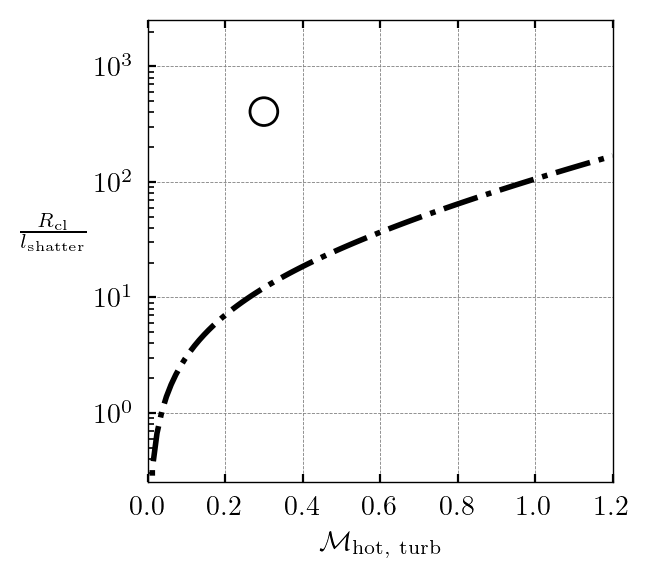

In [5]:
plot_point_bw(trial = '240612_0.3_400', verbose = True)

# Color plot

## Add params

In [6]:
# add the params to file
def save_params(trial, trial_x_val, trial_y_val, rp, l_shatter_min, log_mass_frac, t_cool_mix, t_cool_min, csvpath=f'/freya/ptmp/mpa/wuze/data/cloud.csv'):
    import pandas as pd
    df = pd.read_csv(csvpath, index_col=False, comment='#')
    # display(df)
    
    params_dict = {
        'trial' : trial,
        'x_mach' : trial_x_val,
        'y' : trial_y_val,
        'r_cl' : rp['cloud_radius'],
        'l_shat' : l_shatter_min,
        'log_cloud_mass' : log_mass_frac,
        'T_cloud' : rp['T_cloud'],
        'T_floor' : rp['T_floor'],
        'chi' : rp['chi'],
        't_cool_mix' : t_cool_mix,
        't_cool_min' : t_cool_min,
    }
    
    # save trial in csv
    print(trial)
    if trial in list(df['trial']):  # if exists
        trial_ind = df.index[df['trial'] == trial][0]
        for col, val in params_dict.items():
            df.at[trial_ind, col] = val
    else:  # if no row with trial name, make one
        new_row = pd.DataFrame(params_dict, index=[0])
        df = pd.concat([df, new_row], ignore_index=True)
    
    # save updated csv
    display(df)
    df.to_csv(csvpath, index=False)

{'trial': '240612_0.8_1200', 'cloud_flag': True, 'T_cloud': 8000.0, 'cloud_radius': 0.005, 'cloud_pos': [0, 0, 0], 'box_size': 0.1, 'grid_dim': 128, 'grid_vol': 2097152, 'grid_mesh': 32, 'T_floor': 8000.0, 'T_cold': 16000.0, 'T_ceil': 100000000.0, 'cooling_flag': True, 'T_hot': 4000000.0, 'rho_hot': 0.1, 'mach': 0.8, 'turb_cons_hdf_path': '/freya/ptmp/mpa/wuze/data/cloud_hdfs/mach_0.3.athdf', 'T_cut': 1000000.0, 'chi': 500.0, 'P_hot': 8.438675409534824e-14, 'v_turb': 0.24870895622274292, 't_eddy': 0.40207639290014285, 'cs_hot': 0.31088619527842865, 'T_mix': 178885.43819998318, 'T_warm': 178885.43819998318, 'dedt': 7.692088617693167e-06, 't_corr': 0.40207639290014285, 'dt_drive': 0.00040207639290014283, 't_cc': 0.4495350733363166, 't_maxc': 0.4495350733363166, 'time_start': 4.495350733363166, 'time_end': 8.990701466726332, 'dt_hdf5': 0.04495350733363166, 'time_cloud': 4.495350733363166}
T_cold = 8000.0
T_hot = 4.00e+06
T_mix = 1.79e+05
t_cool,mix = 3.08e-03
t_cool,cold = 1.01e-01
t_cool

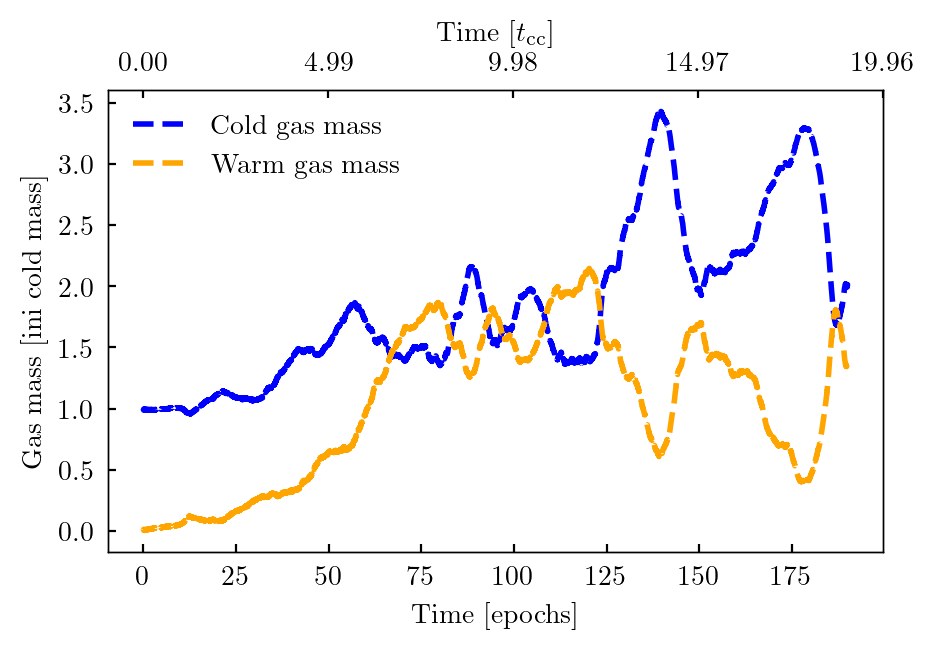

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


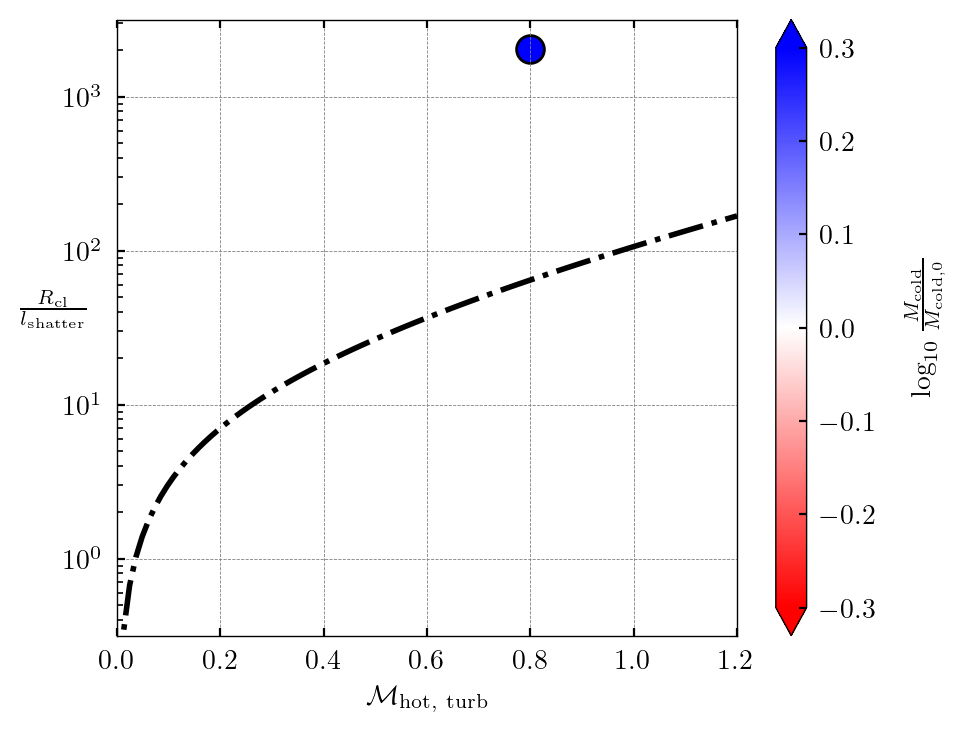

In [7]:
trial, trial_x_val, trial_y_val, rp, l_shatter_min, log_mass_frac, t_cool_mix, t_cool_min =\
plot_point_color(trial = '240612_0.8_1200', verbose = True, cg_st_epoch = 0)

In [8]:
# save_params(trial, trial_x_val, trial_y_val, rp, l_shatter_min, log_mass_frac, t_cool_mix, t_cool_min, csvpath=f'/freya/ptmp/mpa/wuze/data/cloud.csv')

# All params

In [9]:
def plot_params_all(csvpath = f'/freya/ptmp/mpa/wuze/data/cloud.csv'):
    import pandas as pd
    df = pd.read_csv(csvpath, comment='#')
    
    all_x = df['x_mach'].to_numpy()
    all_y = df['y'].to_numpy()
    all_color = df['log_cloud_mass'].to_numpy()
    
    # set cloud and floor temperature text
    if df['T_cloud'][0] == 8e3:
        text_T_cloud = r'$T_{\rm cloud} = 8\times 10^3$'
    elif df['T_cloud'][0] == 4e4:
        text_T_cloud = r'$T_{\rm cloud} = 4\times 10^4$'
    elif df['T_cloud'][0] == 8e2:
        text_T_cloud = r'$T_{\rm cloud} = 8\times 10^2$'
    
    if df['T_floor'][0] == 8e3:
        text_T_floor = r'$T_{\rm floor} = 8\times 10^3$'
    elif df['T_floor'][0] == 4e4:
        text_T_floor = r'$T_{\rm cloud} = 4\times 10^4$'
    elif df['T_floor'][0] == 8e2:
        text_T_floor = r'$T_{\rm cloud} = 8\times 10^2$'

    plt.subplots(figsize=(5,4))
    cm = plt.colormaps['bwr_r']
    
    # scale the fraction
    all_color = np.clip(all_color, -1, 1)
    
    # scatter the points
    sc = plt.scatter(all_x, all_y, marker='o',
                     c=all_color, vmin=-0.3, vmax=0.3, ec='k', cmap=cm)
    
    # annotate with its color value
    for i in range(len(all_x)):
        col = all_color[i]
        if col == 1: col = np.inf
        elif col == -1: col = -np.inf
        col = f'{col:.2f}'.replace('-', '\N{MINUS SIGN}')
        plt.text(all_x[i] + 0.05, all_y[i], col, fontsize=8, ha='left', va='center')
    
    
    # label the temperatures
    plt.text(0.05, 1e3, text_T_cloud, fontsize=10, ha='left', va='center')
    plt.text(0.05, 6e2, text_T_floor, fontsize=10, ha='left', va='center')
    
    # analytical line
    ana_x = np.linspace(0, 1.2, 100)
    ana_y = ana_x * df['t_cool_mix'][0] / df['t_cool_min'][0] * 10. ** (0.6 * ana_x + 0.02)
    plt.plot(ana_x, ana_y, ls='-.', color='k')
    
    # axis
    plt.xlim(0, 1.2)
    plt.ylim(np.power(10., -0.5), np.power(10., 3.5))
    plt.yscale('log')
    plt.xlabel(r'$\mathcal{M}_{\rm hot,\ turb}$')
    plt.ylabel(r'$\frac{R_{\rm cl}}{l_{\rm shatter}}$', rotation=0)
    
    # color bar
    cbar = plt.colorbar(sc, extend='both')
    cbar.ax.set_ylabel(r'$\log_{10} \frac{M_{\rm cold}}{M_{\rm cold, 0}}$', rotation=90, labelpad=10)
    plt.legend()
    plt.grid()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


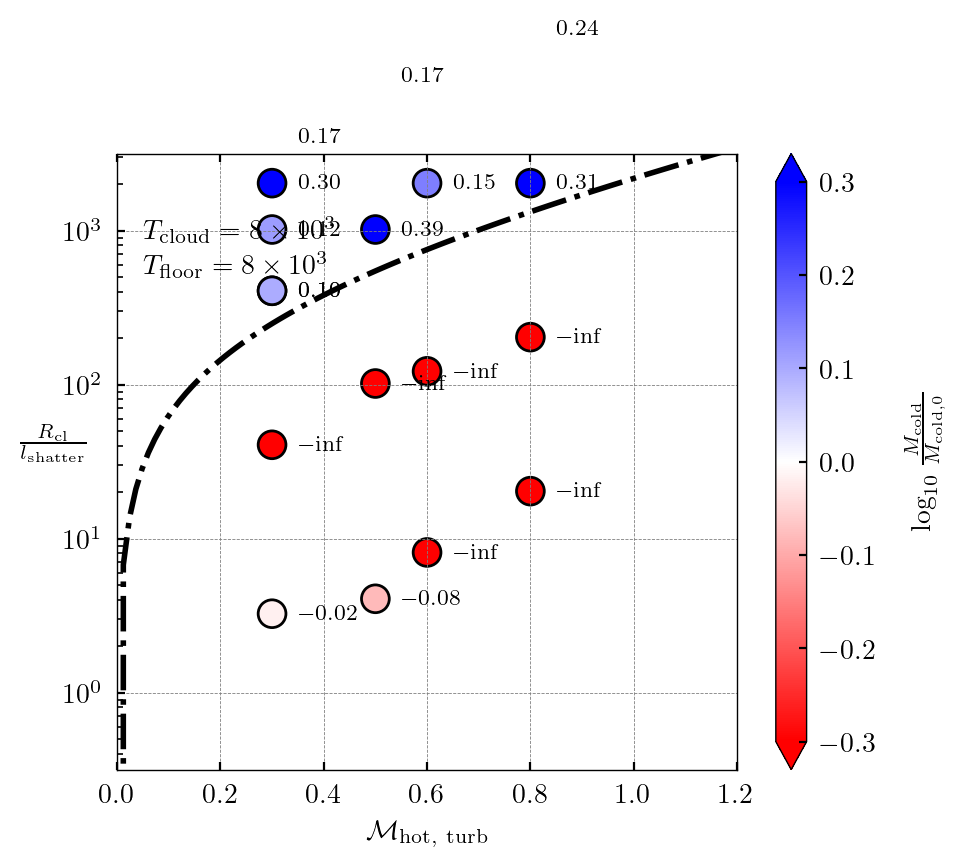

In [10]:
plot_params_all(csvpath = f'/freya/ptmp/mpa/wuze/data/cloud.csv')

# Grab temperature distribution directly

In [11]:
# mass radios of different temperature trials

all_trials_mass_ratios = {}

In [12]:
import sys
import os
sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/athena_pp/vis/python'))
from athena_read import athdf
import h5py

def get_datamd(fname=None,
               key='rho', verbose=False):
    """
    Get and plot data for 2d/3d runs
    """
    data = athdf(filename=fname,)
    if verbose: print(list(data.keys()))
    try:
        len(data[key])
        return data[key][0] if len(data[key]) == 1 else data[key]
    except:
        return data[key]

In [ ]:
cold_cloud_ratio_list = [2, 3, 5, 10]  # pick from these ratios for the cold gas mass


from tqdm import tqdm

trials_12 = '240612_0.6_120  240612_0.5_100  240612_0.5_4  240612_0.3_40  240612_0.3_3  240612_0.8_120  240612_0.8_12  240613_0.1_10  240612_0.3_400  240610_0.6_8  240610_0.6_2032'.split('  ')
trials_18 = '240618_0.3_4000  240618_0.5_10000  240618_0.6_20320  240618_0.8_12000  240618_0.3_400  240618_0.5_1000  240618_0.8_1200'.split('  ')

for trial in np.concatenate([trials_12, trials_18]):
    print(trial)
    print('-' * 50)
    print('\n' * 5)
    datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'

    """read parameters"""
    with open(f'{datapath}/params.pickle', 'rb') as handle:
        rp = pickle.load(handle)
    
    """construct a list of files"""
    file_list = np.sort([f'{datapath}/cloud/{f}' for f in os.listdir(f'{datapath}/cloud') if f.startswith('Turb.out2') and f.endswith('.athdf')])
    end_epoch = int(file_list[-1].split('.')[-2])
    
    time_athdf = []  # time array for the athdfs
    mass_athdf = []  # mass array for the athdfs
    temperature_athdf = []  # temperature dist for the athdfs
    
    mass_fl = []  # mass dist of FIRST AND LAST athdfs
    temperature_fl = []  # mass dist of FIRST AND LAST athdfs
    
    # calculate grid volume
    grid_size = 1 / rp['grid_dim'] ** 3
    
    i = 0
    for fname in tqdm(file_list):
        t = get_datamd(fname=fname, verbose=False, key='Time')
        rho = get_datamd(fname=fname, verbose=False, key='rho').flatten()
        press = get_datamd(fname=fname, verbose=False, key='press').flatten()
        temperature = calc_T(press, rho)
    
        # append
        # if first or last file, get ratio
        if i in [0, len(file_list)-1]:
            print(f'FL recorded at {fname.split('/')[-1]}')
            mass_fl.append(rho * grid_size)
            temperature_fl.append(temperature)
        # regular intervals
        time_athdf.append(t)
        mass_athdf.append(rho * grid_size)
        temperature_athdf.append(temperature)
        i += 1

    # save as pickles
    import pickle
    with open(f'{datapath}/cloud/time_temperature', 'wb') as handle:
        # append the time, temperature, and mass evolutions
        pickle.dump([time_athdf, temperature_athdf, mass_athdf], handle, protocol=pickle.HIGHEST_PROTOCOL)

    """dictionary of cold / warm / hot gas mass ratios"""
    # corresponds to different definitions of cold gas mass
    mass_ratios = {} # temperature: [cold, warm, hot]
    
    for cold_cloud_ratio in cold_cloud_ratio_list:
        # calculate cold gas temperature
        T_cold = rp['T_cloud'] * cold_cloud_ratio
        
        # select cold and hot gas densities
        cgr = np.sum(mass_fl[-1][temperature_fl[-1] <= T_cold])\
        / np.sum(mass_fl[0][temperature_fl[0] <= T_cold])
        wgr = np.sum(mass_fl[-1][np.logical_and(temperature_fl[-1] > T_cold, temperature_fl[-1] <= rp['T_warm'])])\
        / np.sum(mass_fl[0][temperature_fl[0] <= T_cold])  # divide warm gas by cold gas mass
        hgr = np.sum(mass_fl[-1][temperature_fl[-1] > rp['T_cut']])\
        / np.sum(mass_fl[0][temperature_fl[0] > rp['T_cut']])
    
        mass_ratios[cold_cloud_ratio] = [cgr, wgr, hgr]
    
    print(mass_ratios)
    all_trials_mass_ratios[trial] = mass_ratios

In [14]:
# # load pickle
# import pickle
# with open(f'{datapath}/cloud/time_temperature', 'rb') as handle:
#     time_athdf, temperature_athdf, mass_athdf = pickle.load(handle)

In [ ]:
list(all_trials_mass_ratios.keys())

In [ ]:
print(all_trials_mass_ratios)
with open(f'/freya/ptmp/mpa/wuze/data/all_trials_mass_ratios', 'wb') as handle:
    pickle.dump(all_trials_mass_ratios, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Varying time

In [62]:
trial = '240612_0.8_1200'

In [ ]:
"""
Plots the temperature distribution on top of the cooling curve
Varies time
----------
time_athdf
temperature_athdf
"""

datapath = f'/freya/ptmp/mpa/wuze/data/{trial}'

import pickle
"""read parameters"""
with open(f'{datapath}/params.pickle', 'rb') as handle:
    rp = pickle.load(handle)

"""read pickle"""
with open(f'{datapath}/cloud/time_temperature', 'rb') as handle:
    time_athdf, temperature_athdf = pickle.load(handle)

# Import the cooling function from Hitesh's scripts
import sys
sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/athena/cooling_scripts'))
import cooling_fn as cf
sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/athena/helper_scripts'))
import v_turb as vt

# temperature range
T_arr = np.logspace(np.log10(rp['T_floor']),
                    np.log10(rp['T_ceil']), 100)  # in kelvin
rho_arr = rp['rho_hot'] * rp['T_hot'] / T_arr

"""
Cooling & Heating functions
"""
Gamma_n_arr = 1e-26 / rho_arr
Lambda_arr = np.vectorize(cf.Lam_fn_powerlaw)(T_arr, Zsol=1.0, Lambda_fac=1.0)

"""
Cooling & Heating rates
"""
heating_rate = 1e-26 * rho_arr
cooling_rate = Lambda_arr * rho_arr**2

"""
Timescale
"""
tcool_arr = np.vectorize(cf.tcool_calc)(
    rho_arr, T_arr, Zsol=1.0, Lambda_fac=1.0, fit_type="max"
)

def plot_tvlines(ax):
    ax.axvline(x=rp['T_floor'], color="k", linestyle="--")
    ax.axvline(x=rp['T_cloud'], color="slateblue", linestyle="--")
    ax.axvline(x=rp['T_mix'], color="green", linestyle="--", alpha=0.2)
    ax.axvline(x=rp['T_hot'], color="orangered", linestyle="--")
    # ax.axvline(x=T_cut color="k", linestyle="")

def plot_format(ax):
    ax.set_xlim(400, 2e7)
    ax.set_ylim(1e0, 1e6)
    ax.set_ylabel('Counts', fontsize=14)
    ax.set_xlabel(r"$T$(K)", fontsize=14)
    ax.set_yscale("log")
    ax.set_xscale("log")

In [ ]:
%matplotlib widget
from matplotlib.widgets import Button, Slider

fig, ax = plt.subplots(figsize=(7, 4))
nbins = 1000

# histogram
_, _, hist = ax.hist(temperature_athdf[0].flatten(), alpha=0.5,
                bins=np.logspace(np.log10(400), np.log10(2e7), nbins))
plot_format(ax)
plot_tvlines(ax)

# make the timescale plots
ax2 = ax.twinx()
ax2.axhline(y=rp['t_eddy'], color="k", linestyle="-", alpha=0.2, label=r"$t_{\rm eddy}$")
ax2.plot(T_arr, tcool_arr, label=r"$t_{\rm cool}$")
ax2.set_ylim(1e-4, 1e2)
ax2.set_ylabel('Timescale [u]', fontsize=14)
ax2.set_yscale("log")

ax2.legend()

"""
Interactive plot
"""
# Make a horizontal slider to control the T_cold
ax_slider = fig.add_axes([0.25, 0.90, 0.5, 0.05])
time_slider = Slider(
    ax=ax_slider,
    label='Time',
    valmin=0,
    valmax=len(time_athdf)-1,
    valinit=0,
    valfmt='%1.0f',
    valstep=1,
)

# The function to be called anytime a slider's value changes
def update(val):
    index = int(time_slider.val)
    ax.cla()
    n, bins, patches = ax.hist(temperature_athdf[index].flatten(), alpha=0.5,
                                bins=np.logspace(np.log10(400), np.log10(2e7), nbins))
    plot_format(ax)
    plot_tvlines(ax)
    fig.canvas.draw_idle()

time_slider.on_changed(update)  # register the update function with each slider

# Create a button to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.9, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')
def reset(event):
    time_slider.reset()
button.on_clicked(reset)
plt.show()
%matplotlib inline
plotting_def()

## Varying temperature

In [ ]:
%matplotlib widget
from matplotlib.widgets import Button, Slider


csvpath = f'/freya/ptmp/mpa/wuze/data/cloud.csv'



import pandas as pd
df = pd.read_csv(csvpath, comment='#')

all_x = df['x_mach'].to_numpy()
all_y = df['y'].to_numpy()
all_color = df['log_cloud_mass'].to_numpy()

# set cloud and floor temperature text
if df['T_cloud'][0] == 8e3:
    text_T_cloud = r'$T_{\rm cloud} = 8\times 10^3$'
elif df['T_cloud'][0] == 4e4:
    text_T_cloud = r'$T_{\rm cloud} = 4\times 10^4$'
elif df['T_cloud'][0] == 8e2:
    text_T_cloud = r'$T_{\rm cloud} = 8\times 10^2$'

if df['T_floor'][0] == 8e3:
    text_T_floor = r'$T_{\rm floor} = 8\times 10^3$'
elif df['T_floor'][0] == 4e4:
    text_T_floor = r'$T_{\rm cloud} = 4\times 10^4$'
elif df['T_floor'][0] == 8e2:
    text_T_floor = r'$T_{\rm cloud} = 8\times 10^2$'

fig, ax = plt.subplots(figsize=(5,4))
cm = plt.colormaps['bwr_r']

# scale the fraction
all_color = np.clip(all_color, -1, 1)

# scatter the points
sc = plt.scatter(all_x, all_y, marker='o',
                 c=all_color, vmin=-0.3, vmax=0.3, ec='k', cmap=cm)

# annotate with its color value
txts = []
for i in range(len(all_x)):
    col = all_color[i]
    if col == 1: col = np.inf
    elif col == -1: col = -np.inf
    col = f'{col:.2f}'.replace('-', '\N{MINUS SIGN}')
    txt = plt.text(all_x[i] + 0.05, all_y[i], col, fontsize=8, ha='left', va='center')
    txts.append(txt)


# label the temperatures
plt.text(0.05, 1e3, text_T_cloud, fontsize=10, ha='left', va='center')
plt.text(0.05, 6e2, text_T_floor, fontsize=10, ha='left', va='center')

# analytical line
ana_x = np.linspace(0, 1.2, 100)
ana_y = ana_x * df['t_cool_mix'][0] / df['t_cool_min'][0] * 10. ** (0.6 * ana_x + 0.02)
plt.plot(ana_x, ana_y, ls='-.', color='k')

# axis
plt.xlim(0, 1.2)
plt.ylim(np.power(10., -0.5), np.power(10., 3.5))
plt.yscale('log')
plt.xlabel(r'$\mathcal{M}_{\rm hot,\ turb}$')
plt.ylabel(r'$\frac{R_{\rm cl}}{l_{\rm shatter}}$', rotation=0)

# color bar
cbar = plt.colorbar(sc, extend='both')
cbar.ax.set_ylabel(r'$\log_{10} \frac{M_{\rm cold}}{M_{\rm cold, 0}}$', rotation=90, labelpad=10)
plt.legend()
plt.grid()


"""
Interactive plot
"""
# Make a horizontal slider to control the T_cold
ax_slider = fig.add_axes([0.25, 0.90, 0.5, 0.05])
Tcold_slider = Slider(
    ax=ax_slider,
    label=r'$T_{\rm cold}$',
    valmin=np.min(cold_cloud_ratio_list),
    valmax=np.max(cold_cloud_ratio_list),
    valinit=np.min(cold_cloud_ratio_list),
    valstep=cold_cloud_ratio_list,
)

# The function to be called anytime a slider's value changes
def update(T):
    # if the value has a color in the dictionary
    cg_col_list = []
    for i, trial in enumerate(df['trial']):
        try:
            # grab a new color
            cgr = all_trials_mass_ratios[trial][T][0] # cold gas mass
            cg_col = np.clip(np.log10(cgr), -1, 1)
            cg_col_list.append(cg_col)  # append NEW COLOR value
            
            # make a new text
            if cg_col == 1: cg_col = np.inf
            elif cg_col == -1: cg_col = -np.inf
            cg_col = f'{cg_col:.2f}'.replace('-', '\N{MINUS SIGN}')

            # set new text
            txts[i].set_text(cg_col)
        except:
            cg_col_list.append(all_color[i])  # append old value
            # don't set text
    # set new color to list
    sc.set_colors(cg_col_list)
    sc.set_facecolors(cg_col_list)
    sc.set_edgecolors(cg_col_list)
    fig.canvas.draw_idle()

Tcold_slider.on_changed(update)  # register the update function with each slider

# Create a button to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.9, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')
def reset(event):
    Tcold_slider.reset()
button.on_clicked(reset)
plt.show()
%matplotlib inline
plotting_def()